In [1]:
import csv
import os
import io
import time
import requests
import numpy as np
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from astropy.table import Table, vstack
from astropy.io import fits, ascii
from scipy.signal import medfilt
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import fitting, models
from astropy.cosmology import Planck15
from astropy import units as u

from desispec.io import read_spectra, read_fibermap
from prospect.mycoaddcam import coadd_brz_cameras
from desitarget.targetmask import desi_mask

In [2]:
class DesiRedshiftTable:
    
    '''This is a class intended for use on tables structured such that it contains the columns:

        'TARGETID' : unique target id assigned to DESI object
        'Z' : best redshift calculated from Redrock pipeline
        'ZWARN' : bitmask assigned to quality of calculated z from redrock
        'SPECTYPE' : spectral type assigned by DESI Spectroscopic pipeline
        'target_ra' : target right ascension given for DESI fiber assignment
        'target_dec' : target declination given for DESI fiber assignment
        'FIBERSTATUS' : bitmask assigned for fiber conditions during observation
        'DESI_TARGET' : bitmask assigned by DESI describing the type of target 
                        and conditions during observation
        'LAST_TILEID' : last tile the target was observed on
        'LAST_NIGHT' : last night the target was assigned through

       at a minimum.
       This class can return a table of data from targets to date which have a
       calculated redshift and apply cuts to this table or any table with similar formatting.
    '''
    
    
    def __init__(self, t, desi_targetid, z, zwarn, spectype, fiberstatus, desi_target):
        self.t = t
        self.tid = desi_targetid.name
        self.z = z.name
        self.zwarn = zwarn.name
        self.spectype = spectype.name
        self.fiberstatus = fiberstatus.name
        self.desi_target = desi_target.name
    
    
    def qual_cuts(self):
        '''Implements numerous quality cuts.'''
        isGAL = ((self.t[self.desi_target] & desi_mask.mask("QSO|LRG|ELG|BGS_ANY")) == 0)
        fiberstat = (self.t[self.fiberstatus] != 0)
        zwarn = (self.t[self.zwarn] != 0)
        bright_obj = (self.t[self.desi_target] & desi_mask.mask("NEAR_BRIGHT_OBJECT|IN_BRIGHT_OBJECT|BRIGHT_OBJECT|NO_TARGET") != 0)
        isSPECTYPE = (self.t[self.spectype]=='STAR')
        isb = np.where(isGAL | fiberstat | zwarn | bright_obj | isSPECTYPE)[0]
        self.t.remove_rows([isb])
    
    def add_angsep_dl(self):
        '''Adds columns for the luminosity distance of a redshift value and angular separation of 300 kpc.'''
        self.t.add_columns([self.d_lumin(self.t[self.z]), self.ang_sep(self.t[self.z],300)], names=['dL', 'ang_sep'])
    
    def min_cuts(self):
        '''Implements a minimum on the redshift values of a table and corrects the spectype for negative redshifts.'''
        self.t[self.spectype][(self.t[self.z] < 0)] = 'STAR'  # The redrock redshifts < 0 are blueshifted stars moving towards us
        self.t['ang_sep'][(self.t[self.z] < 0.01)] = 0.001  # Sets a minimum angular separation for low redshifts
        self.t['dL'][(self.t[self.z] < 0.01)] = self.d_lumin(0.01)  # Sets luminosity distance to match the angular separation limit on low redshifts
        self.t.sort('ang_sep')

    @staticmethod
    def d_lumin(z):
        '''Returns the luminosity distance in kpc calculated from the redshift value.'''
        return Planck15.luminosity_distance(z=z).value*1000
    
    @staticmethod
    def ang_sep(z,d):
        '''Returns the angular separation in degrees for a distance of d in kpc determined from the 
        luminosity distance at a specific redshift.
        '''
        return (d/(Planck15.luminosity_distance(z=z).value*1000))*(180/np.pi)
    
    @staticmethod
    def all_z_todate():
        '''Returns a table containing data of all targets that have a calculated redshift from redrock to date.'''
        start = time.time()
        basedir = os.environ['DESI_SPECTRO_REDUX']
        redux = 'daily/tiles/cumulative'
        zbest_paths = glob(f'{basedir}/{redux}/**/zbest*.fits', recursive=True)
        tabs = [Table.read(path, 'ZBEST')['TARGETID','Z','ZERR','ZWARN','SPECTYPE','SUBTYPE'] for path in zbest_paths]
    
        for i,tab in enumerate(tabs):
            s = Table.read(zbest_paths[i].replace('zbest', 'coadd'), 'FIBERMAP')
            tab.add_columns([s['TARGET_RA'],s['TARGET_DEC'],s['FIBERSTATUS'],s['DESI_TARGET'],s['LAST_TILEID'],s['LAST_NIGHT'],
                             zbest_paths[i].split("zbest-")[1][0],zbest_paths[i].replace('zbest', 'coadd'),list(range(0,500))], 
                            names=['target_ra','target_dec','FIBERSTATUS','DESI_TARGET','LAST_TILEID','LAST_NIGHT',
                                   'spectro','coadd_file','coadd_index']
                           )
        
        end = (time.time() - start)/60
        print(f"  Total time: {end:0.3} min")
        
        return vstack(tabs)

In [3]:
z_tab = DesiRedshiftTable.all_z_todate()

  Total time: 69.7 min


In [4]:
z_tab.info

<Table length=7674000>
    name     dtype  n_bad
----------- ------- -----
   TARGETID   int64     0
          Z float64     0
       ZERR float64     0
      ZWARN   int64     0
   SPECTYPE  bytes6     0
    SUBTYPE bytes20     0
  target_ra float64  8398
 target_dec float64  8398
FIBERSTATUS   int32     0
DESI_TARGET   int64     0
LAST_TILEID   int32     0
 LAST_NIGHT   int32     0
    spectro    str1     0
 coadd_file  str108     0
coadd_index   int64     0

In [5]:
t = DesiRedshiftTable(z_tab, z_tab['TARGETID'], z_tab['Z'], z_tab['ZWARN'], z_tab['SPECTYPE'], z_tab['FIBERSTATUS'], z_tab['DESI_TARGET'])
t.qual_cuts()
t.add_angsep_dl()
t.min_cuts()

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/table/table.py:2226: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


In [6]:
t.t

TARGETID,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,target_ra,target_dec,FIBERSTATUS,DESI_TARGET,LAST_TILEID,LAST_NIGHT,spectro,coadd_file,coadd_index,dL,ang_sep
int64,float64,float64,int64,bytes6,bytes20,float64,float64,int32,int64,int32,int32,str1,str108,int64,float64,float64
39628273344317750,5.975007710622815,0.0009489629700856442,0,QSO,,199.89061662514084,20.585806114429367,0,655394,81103,20210512,5,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81103/20210512/coadd-5-81103-thru20210512.fits,93,58760452.904516906,0.0002925221471974632
39627897454987920,5.9343098050522185,0.000704201061041564,0,QSO,,242.29358246914828,4.5933511145208525,0,655394,1405,20210517,5,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/1405/20210517/coadd-5-1405-thru20210517.fits,273,58295585.623634666,0.000294854810532273
39628497420813690,5.914249444101669,0.0015011001988227979,0,QSO,,251.20054487307772,30.73136788568804,0,655394,81110,20210513,4,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81110/20210513/coadd-4-81110-thru20210513.fits,236,58066582.902881,0.0002960176575686163
39633145301041290,5.890074941769152,0.001099214845538784,0,QSO,,242.07950135427174,43.74663125869681,0,2594,1726,20210609,5,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/1726/20210609/coadd-5-1726-thru20210609.fits,313,57790733.21392332,0.00029743062421958466
39633171356059987,5.887798116295597,0.0006247145400374305,0,QSO,,254.1071609381406,45.22468032034102,0,2594,1760,20210615,5,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/1760/20210615/coadd-5-1760-thru20210615.fits,328,57764759.59391967,0.0002975643623337088
39628250581829319,5.8322857075136225,0.0005113655050051559,0,QSO,,198.6130338133914,19.43185187450744,0,1179778,81105,20210512,2,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81105/20210512/coadd-2-81105-thru20210512.fits,162,57131843.65459034,0.00030086082916989227
39628250581829319,5.831892382400327,0.00036852581291779555,0,QSO,,198.6130338133914,19.43185187450744,0,1179778,81106,20210512,2,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81106/20210512/coadd-2-81106-thru20210512.fits,162,57127361.6972828,0.0003008844333650063
39633438721970255,5.8314914860519,0.00047305952585896495,0,QSO,,284.95006285807904,64.40480584912682,0,257,81115,20210513,2,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81115/20210513/coadd-2-81115-thru20210513.fits,166,57122793.501426525,0.0003009084955464484
39628250581829319,5.830077480486494,0.00024028948048427902,0,QSO,,198.6130338133914,19.43185187450744,0,1179778,81102,20210512,2,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81102/20210512/coadd-2-81102-thru20210512.fits,162,57106681.26194464,0.00030099339471472856


In [7]:
ascii.write(t.t, './DESI_ZTF/data/allz_qualcuts.csv', format='csv')

In [33]:
def plot_host(gal_ra, gal_dec, t_ra, t_dec, **kwargs):
    """ Plots a cutout from the Legacy Survey using DR9 layer and marks the locations 
    of a galaxy and transient within 60" of each other.

    Parameters
    ----------
    gal_ra : Right ascension of galaxy.
    gal_dec : Declination of galaxy.
    t_ra : Right ascension of transient.
    t_dec : Declination of transient.
    
    Optional Parameters
    -------------------
    z : Redshift of galaxy.
    desi_id : Target ID from DESI.
    survey : Survey thar observed the transient.
    t_name : Name or ID assigned to transient from the survey.
    spectype : Spectype assigned by DESI or by visual inspection.
    """
    # Define optional parameters
    opt = {
        'z' : 0,
        'desi_id' : 'None Given',
        'survey': '?',
        't_name' : 'None Given',
        'spectype' : 'None Given',
    }
    opt.update(kwargs)
    
    q3c_ang_sep = 3600*(300/(Planck15.luminosity_distance(z=opt.get('z')).value*1000))*(180/np.pi)
    d_ra = (t_ra-gal_ra)*np.cos(np.abs(gal_dec))*3600
    d_dec = (t_dec-gal_dec)*3600
    t_ang_sep = ((d_ra**2)+(d_dec**2))**(0.5)
    
    # Adjust image size to be sure to capture a cutout that has the transient location in view
    if q3c_ang_sep>30:
        center = 256
        url =  "http://legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&size=512&layer=ls-dr9&pixscale=0.27&bands=grz" %(gal_ra,gal_dec)
        print(url)
        
    if q3c_ang_sep<=30:
        center = 128
        url = "http://legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&size=256&layer=ls-dr9&pixscale=0.27&bands=grz" %(gal_ra,gal_dec)
        print(url)
        
    if t_ang_sep>60:
        print(f'https://www.legacysurvey.org/viewer-desi?ra={gal_ra}&dec={gal_dec}&layer=ls-dr9&zoom=15'.format())
        return print('Angular separation too large for cutout image.')
        
    print(f'https://www.legacysurvey.org/viewer-desi?ra={gal_ra}&dec={gal_dec}&layer=ls-dr9&zoom=15'.format())
    print('DESI TargetID: '+opt.get('desi_id')+'\nSurvey: '+opt.get('survey')+'\nName/ID: '+opt.get('t_name'))
    
    plt.clf()
    plt.figure(figsize=(10,10))
    r = requests.get(url)
    im = Image.open(io.BytesIO(r.content))
    plt.imshow(im)
    
    # Plot a target for galaxy and transient location
    plt.scatter(center+d_ra/0.27, center+d_dec/0.27, marker= 'x', s=100, c='fuchsia', 
                label='Survey: '+opt.get('survey')+f'\nname: '.format()+opt.get('t_name')+f'\nRA: {t_ra :0.2f} deg\nDec: {t_dec :0.2f} deg'.format())
    plt.scatter(np.NaN, np.NaN, marker = '+', s=100, color = 'tab:green', 
                label=f'Galaxy\nTarget ID: '.format()+opt.get('desi_id')+f'\nRA: {gal_ra :0.2f} deg\nDec: {gal_dec :0.2f} deg'.format())
    plt.hlines(center, center+20, center+30, color = 'tab:green')
    plt.hlines(center, center-30, center-20, color = 'tab:green')
    plt.vlines(center, center+20, center+30, color = 'tab:green')
    plt.vlines(center, center-30, center-20, color = 'tab:green')

    # add ellipse displaying the region searched by q3c_join( ) function during cross-matching
    ell = mpl.patches.Ellipse((center,center), width=2*q3c_ang_sep*np.cos(gal_dec)/0.27, height=2*q3c_ang_sep/0.27, edgecolor='red', ls=':', facecolor='none', linewidth=2)
    
    # image scale
    plt.errorbar(im.size[0]-50, im.size[0]-25, xerr=10/0.27/2, color='w', capsize=5)
    plt.text(im.size[0]-50,im.size[0]-15, '10 arcsec', c='w', horizontalalignment='center', verticalalignment='top', size='medium', fontweight='bold')
    
    # compass
    plt.arrow(25,im.size[0]-25,0,-50, 
              color='w', 
              head_width=5)
    plt.arrow(25,im.size[0]-25,50,0, 
              color='w', 
              head_width=5)
    plt.text(25,im.size[0]-90,'N',
             c='w',
             horizontalalignment='center', 
             verticalalignment='center', 
             fontweight='bold')
    plt.text(90,im.size[0]-25,'E',
             c='w',
             horizontalalignment='left', 
             verticalalignment='center', 
             fontweight='bold')
    
    bbox_props=dict(facecolor='w',alpha=0.5)
    legend_properties = {'weight':'bold'}
    plt.gca().add_patch(ell)
    plt.text(15,75,f'spectpye = '.format()+opt.get('spectype')+f'\nz = '+str(opt.get('z'))+f'\nq3c angular separation = {q3c_ang_sep :0.2f}\ncalculated angular separation = {t_ang_sep :0.2f}'.format(), 
             bbox=bbox_props,
             va='bottom',
             fontsize=12)
    plt.legend(fontsize=12, 
               bbox_to_anchor=(1.02,1), 
               loc='upper left', 
               frameon=False, 
               prop=legend_properties, 
               labelspacing=2)
    plt.title("LegSurv DR9 Cutout\ncentered on Desi Target (RA, Dec)", fontsize = 14)
    plt.axis('off')
    plt.show()

In [9]:
t.t.info

<Table length=2204752>
    name     dtype 
----------- -------
   TARGETID   int64
          Z float64
       ZERR float64
      ZWARN   int64
   SPECTYPE  bytes6
    SUBTYPE bytes20
  target_ra float64
 target_dec float64
FIBERSTATUS   int32
DESI_TARGET   int64
LAST_TILEID   int32
 LAST_NIGHT   int32
    spectro    str1
 coadd_file  str108
coadd_index   int64
         dL float64
    ang_sep float64

<ipython-input-33-1d6d479a47d3>:30: RuntimeWarning: divide by zero encountered in double_scalars
  q3c_ang_sep = 3600*(300/(Planck15.luminosity_distance(z=opt.get('z')).value*1000))*(180/np.pi)


http://legacysurvey.org/viewer/cutout.jpg?ra=218.83095590586257&dec=32.850188634029834&size=512&layer=ls-dr9&pixscale=0.27&bands=grz
https://www.legacysurvey.org/viewer-desi?ra=218.83095590586257&dec=32.850188634029834&layer=ls-dr9&zoom=15
DESI TargetID: None Given
Survey: ?
Name/ID: None Given


<Figure size 432x288 with 0 Axes>

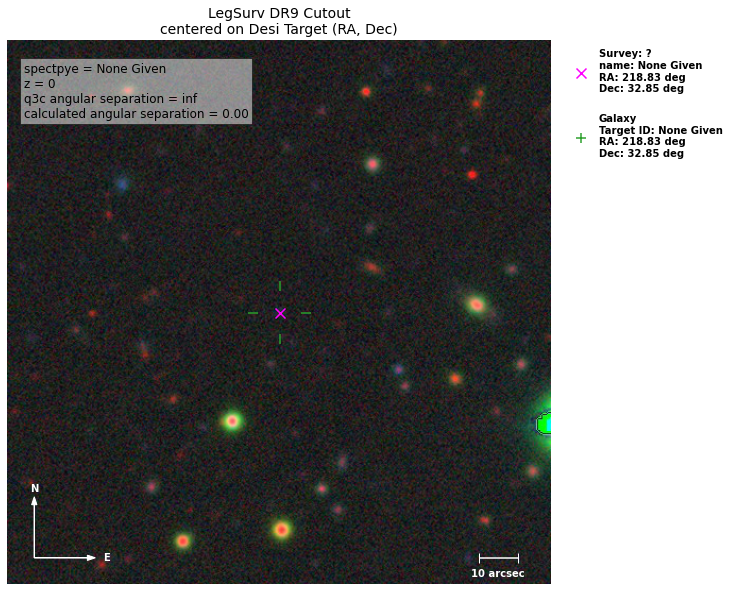

In [34]:
plot_host(t.t['target_ra'][100],t.t['target_dec'][100],t.t['target_ra'][100],t.t['target_dec'][100])

In [44]:
def plot_spec(target_id, spectro, last_tile, last_night, **kwargs):
    
    opt = {
        'ra' : None,
        'dec' : None,
        'z' : 0.1,
        'smoothing' : 4,
        'spectype' : None
    }
    opt.update(kwargs)
    
    basedir = os.environ['DESI_SPECTRO_REDUX']
    redux = 'daily/tiles/cumulative'
    f = f'{basedir}/{redux}/{last_tile}/{last_night}/coadd-{spectro}-{last_tile}-thru{last_night}.fits'
    coadd_obj = read_spectra(f)
    t_id = np.where(coadd_obj.target_ids()==target_id)[0]
         
    if len(t_id)==0:
        print('No matching target id in file.')
        
        if opt.get('ra') is None:
            print('Enter RA and Dec to see legacy survey link.')
            ra,dec = input("RA: "), input("Dec: ")
            return print(f'https://www.legacysurvey.org/viewer-desi?ra={ra}&dec={dec}&layer=ls-dr9&zoom=15'.format())
        
        return print(f'https://www.legacysurvey.org/viewer-desi?ra='+opt.get('ra')+'&dec='+opt.get('dec')+'&layer=ls-dr9&zoom=15')
    
    if len(t_id)>1:
        t_id = t_id[-1]
        
    if len(t_id)==1:
        t_id = t_id[0]
    
    if opt.get('ra') is not None:
        print(f'https://www.legacysurvey.org/viewer-desi?ra='+str(opt.get('ra'))+'&dec='+str(opt.get('dec'))+'&layer=ls-dr9&zoom=15')
    
    kernel = Gaussian1DKernel(stddev=opt.get('smoothing'))
    med_filt_size = 19

    wave_arr = [coadd_obj.wave["b"],coadd_obj.wave["r"],coadd_obj.wave["z"]]
    flux_arr = [coadd_obj.flux["b"][t_id],coadd_obj.flux["r"][t_id],coadd_obj.flux["z"][t_id]]
    noise_arr = [np.sqrt(coadd_obj.ivar["b"][t_id])**(-1.0),np.sqrt(coadd_obj.ivar["r"][t_id])**(-1.0),np.sqrt(coadd_obj.ivar["z"][t_id])**(-1.0)]
    
    x_spc, y_flx, y_err = coadd_brz_cameras(wave_arr,flux_arr,noise_arr)
    
    smooth_yflx = convolve(y_flx, kernel)
    continuum = medfilt(y_flx, med_filt_size)
    
    # Define emission/absorption lines based on spectral type
    if opt.get('spectype')=='QSO':
        elines = np.array([1216, 1546, 1906, 2800, 4853, 4960, 5008])
        enames = ['Ly\u03B1','C[IV]','C[III]','Mg[II]','','O[III]','O[III]']
        alines = np.array([911.7,1393.7,1402.7,1548.2,1550.8,2382.7,2600.2,2796.3,2803.5])
        anames = ['Ly limit','Si[IV]','Si[IV]','C[IV]','C[IV]','Fe[II]','Fe[II]','Mg[II]','Mg[II]']
    
    if opt.get('spectype')=='GALAXY':
        elines=np.array([3727.1,3729.9,4102.9,4341.7,4862.7,4960.3,5008.2,6549.8,6585.3,6564.6,6718.3,6732.7])
        enames = ['O[II]','O[II]','H\u03B4','H\u03B3','H\u03B2','O[III]','O[III]','N[II]','N[II]','H\u03B1','S[II]','S[II]']
        alines = np.array([3934.8,3969.6,4305.6,5176.7,5895.6,8498,8542,8662])
        anames = ['Ca(K)','Ca(H)','G-band','Mg','Na','CaT','CaT','CaT']
        
    # y = np.concatenate((continuum, y_err))
    xmin, xmax, ymin, ymax = np.nanmin(coadd_obj.wave['b']), np.nanmax(coadd_obj.wave['z']), np.nanmin(continuum[~np.isinf(continuum)]), np.nanmax(continuum[~np.isinf(continuum)])
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(25, 7))
    for cam in ['b','r','z']:
        plt.plot(coadd_obj.wave[cam], coadd_obj.flux[cam][t_id], 'lightseagreen', alpha=0.25, linewidth=0.5)
    plt.plot(np.NaN, np.NaN, 'lightseagreen', linewidth=1, label='data')
    plt.plot(x_spc, y_err, 'cornflowerblue', alpha=0.75, linewidth=1, label='noise')
    plt.plot(x_spc, continuum, 'mediumorchid', alpha=1, linewidth=1, label='Gaussian Fit')
    if opt.get('spectype') is not None:
        pos = ymax/3
        for i,line in enumerate(elines):
            if ((1+opt.get('z'))*line > np.min(coadd_obj.wave["b"])) & ((1+opt.get('z'))*line < np.max(coadd_obj.wave["z"])):
                pos += 5
                pos = pos%ymax
                if pos<(ymax/3):
                    pos = ymax/3
                plt.axvline((1+opt.get('z'))*line, color='coral', alpha=0.5, linewidth=3)
                plt.text((1+opt.get('z'))*line, pos, f"{enames[i]}", rotation=90,va='center', ha = 'right', fontsize=16)
        for i,line in enumerate(alines):
            if ((1+opt.get('z'))*line > np.min(coadd_obj.wave["b"])) & ((1+opt.get('z'))*line < np.max(coadd_obj.wave["z"])):
                pos += 5
                pos = pos%ymax
                if pos<(ymax/3):
                    pos = ymax/3
                plt.axvline((1+opt.get('z'))*line, color='hotpink', alpha=0.5, linewidth=3)
                plt.text((1+opt.get('z'))*line, pos, f"{anames[i]}", rotation=90,va='center', ha = 'right', fontsize=16)
    plt.plot(np.NaN, np.NaN, 'coral', linewidth=1, label='emission')
    plt.plot(np.NaN, np.NaN, 'hotpink', linewidth=1, label='absorption')
    plt.axis([xmin, xmax, ymin-1, ymax+1]) 
    plt.legend(fontsize=18)
    plt.xlabel('wavelength $\lambda [\AA]$', fontsize=18)
    plt.ylabel('Flux [erg/s/cm2/$\AA$]', fontsize=18)
    plt.title(f'DESI Target ID: {target_id}', fontsize=18)

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
t.t[0]

TARGETID,Z,ZERR,ZWARN,SPECTYPE,SUBTYPE,target_ra,target_dec,FIBERSTATUS,DESI_TARGET,LAST_TILEID,LAST_NIGHT,spectro,coadd_file,coadd_index,dL,ang_sep
int64,float64,float64,int64,bytes6,bytes20,float64,float64,int32,int64,int32,int32,str1,str108,int64,float64,float64
39628273344317750,5.975007710622815,0.0009489629700856442,0,QSO,,199.89061662514084,20.585806114429367,0,655394,81103,20210512,5,/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81103/20210512/coadd-5-81103-thru20210512.fits,93,58760452.904516906,0.0002925221471974632


INFO:spectra.py:253:read_spectra: iotime 0.543 sec to read coadd-2-1573-thru20210517.fits at 2021-07-30T18:42:41.800405
https://www.legacysurvey.org/viewer-desi?ra=193.91371577733554&dec=-8.017282650686907&layer=ls-dr9&zoom=15


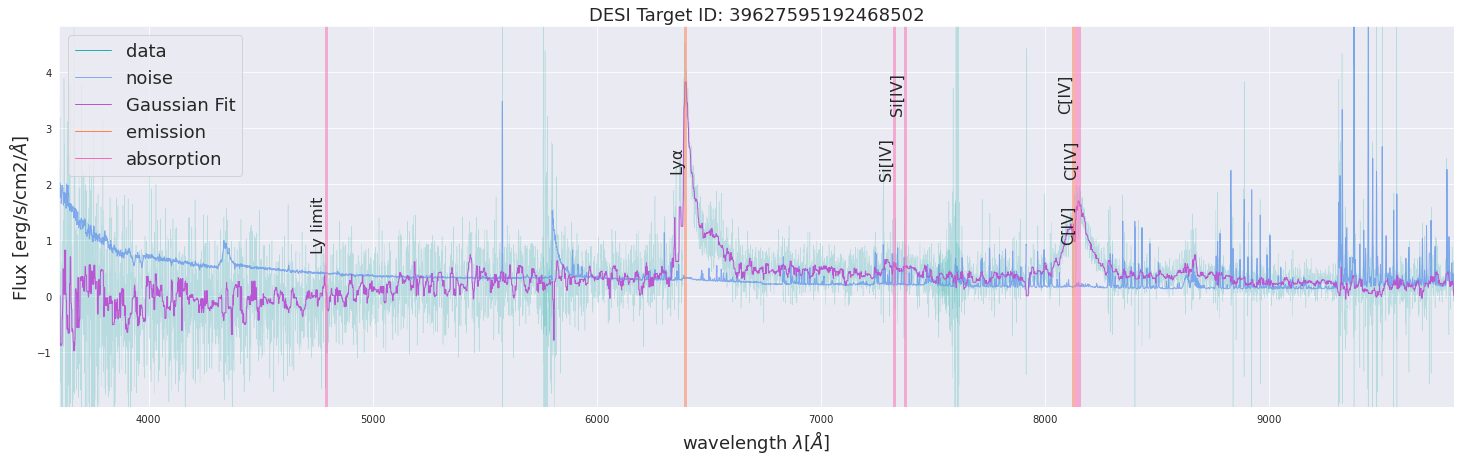

In [59]:
i=900
plot_spec(t.t['TARGETID'][i],
          t.t['spectro'][i],
          t.t['LAST_TILEID'][i],
          t.t['LAST_NIGHT'][i],
          ra= t.t['target_ra'][i],
          dec= t.t['target_dec'][i],
          spectype = t.t['SPECTYPE'][i],
          z = t.t['Z'][i]
         )